In [1]:
import json
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

from models.brain_class_encoder import BrainClassifierV1, BrainClassifierV3
from dataloaders.conditional_loaders import ClassConditionalLoader, ECOGLoader, get_word_from_filepath

/home/passch/.conda/envs/diffwave/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Data Preparation

In [3]:
USE_ALL_55_CLASSES = True

In [4]:
data_base_dir = Path('/home/passch/data/')
data_path = data_base_dir / 'HP1_ECoG_conditional/denoised_fixed-transcript_cleaned'
splits_path = data_base_dir / 'datasplits/HP1_ECoG_conditional/denoised_fixed-transcript_cleaned'

if USE_ALL_55_CLASSES:
    with open(splits_path / 'train.csv', 'r') as f:
        train_files = [fn.replace('.wav','.npy') for fn in f.read().split(',')]
    with open(splits_path / 'val.csv', 'r') as f:
        val_files = [fn.replace('.wav','.npy') for fn in f.read().split(',')]
    n_classes = 55
    print(len(train_files), len(val_files))
else:
    # Remove all files that occur only once or twice (leaving 16 classes)
    cleaned_files = ['dag1.npy', 'dag10.npy', 'dag11.npy', 'dag12.npy', 'dag2.npy', 'dag3.npy', 'dag4.npy', 'dag5.npy', 'dag6.npy', 'dag7.npy', 'dag8.npy', 'dag9.npy', 'goed1.npy', 'goed4.npy', 'goed5.npy', 'goed7.npy', 'heel1.npy', 'heel2.npy', 'heel3.npy', 'heel4.npy', 'hoofd1.npy', 'hoofd2.npy', 'hoofd3.npy', 'hoofd4.npy', 'hoofd5.npy', 'hoofd6.npy', 'hoofd7.npy', 'hoop1.npy', 'hoop2.npy', 'hoop3.npy', 'kan1.npy', 'kan2.npy', 'kan4.npy', 'kan5.npy', 'kan6.npy', 'keer1.npy', 'keer2.npy', 'keer3.npy', 'keer4.npy', 'keer5.npy', 'keer6.npy', 'land1.npy', 'land2.npy', 'land3.npy', 'land4.npy', 'lang1.npy', 'lang2.npy', 'lang3.npy', 'los2.npy', 'los3.npy', 'los4.npy', 'los5.npy', 'meer1.npy', 'meer2.npy', 'meer4.npy', 'meer5.npy', 'meer6.npy', 'paar2.npy', 'paar3.npy', 'paar4.npy', 'paar5.npy', 'paar6.npy', 'paar7.npy', 'paar8.npy', 'tijd1.npy', 'tijd2.npy', 'tijd3.npy', 'tijd4.npy', 'vroeg1.npy', 'vroeg2.npy', 'vroeg3.npy', 'vroeg4.npy', 'weg1.npy', 'weg2.npy', 'weg3.npy', 'wel1.npy', 'wel10.npy', 'wel12.npy', 'wel14.npy', 'wel2.npy', 'wel3.npy', 'wel4.npy', 'wel5.npy', 'wel6.npy', 'wel7.npy', 'wel8.npy', 'wel9.npy']

    words = list(np.unique([get_word_from_filepath(fn) for fn in cleaned_files]))
    n_classes = len(words) # 16 different words

    # Make manual train/val split. Words are chosen randomly but such that there are more in the val split for those 
    # words that also occur more often
    train_files = ['dag1.npy', 'dag10.npy', 'dag11.npy', 'dag12.npy', 'dag3.npy', 'dag4.npy', 'dag5.npy', 'dag6.npy', 'dag7.npy', 'dag9.npy', 'goed1.npy', 'goed4.npy', 'goed7.npy', 'heel2.npy', 'heel3.npy', 'heel4.npy', 'hoofd1.npy', 'hoofd3.npy', 'hoofd4.npy', 'hoofd5.npy', 'hoofd6.npy', 'hoop1.npy', 'hoop3.npy', 'kan1.npy', 'kan2.npy', 'kan4.npy', 'kan5.npy', 'keer2.npy', 'keer3.npy', 'keer5.npy', 'keer6.npy', 'land1.npy', 'land3.npy', 'land4.npy', 'lang1.npy', 'lang2.npy', 'los2.npy', 'los3.npy', 'los5.npy', 'meer1.npy', 'meer2.npy', 'meer5.npy', 'meer6.npy', 'paar2.npy', 'paar4.npy', 'paar5.npy', 'paar6.npy', 'paar7.npy', 'tijd1.npy', 'tijd3.npy', 'tijd4.npy', 'vroeg2.npy', 'vroeg3.npy', 'vroeg4.npy', 'weg2.npy', 'weg3.npy', 'wel1.npy', 'wel10.npy', 'wel12.npy', 'wel14.npy', 'wel2.npy', 'wel3.npy', 'wel5.npy', 'wel6.npy', 'wel8.npy', 'wel9.npy']

    val_files = ['dag2.npy', 'dag8.npy', 'goed5.npy', 'heel1.npy', 'hoofd2.npy', 'hoofd7.npy', 'hoop2.npy', 'kan6.npy', 'keer1.npy', 'keer4.npy', 'land2.npy', 'lang3.npy', 'los4.npy', 'meer4.npy', 'paar3.npy', 'paar8.npy', 'tijd2.npy', 'vroeg1.npy', 'weg1.npy', 'wel4.npy', 'wel7.npy']

    print(len(train_files), len(val_files))

119 15


In [5]:
SEGMENT_LENGTH = 100

if USE_ALL_55_CLASSES:
    class_label_loader = ClassConditionalLoader(data_base_dir / 'HP_VariaNTS_intersection.txt')
else:
    # If using only 16 classes, use the unique words computed above
    class_label_loader = ClassConditionalLoader(words_file=None, words_list=words)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, files, segment_length) -> None:
        super().__init__()
        self.files=files
        self.segment_length=segment_length
    def __getitem__(self, n:int):
        ecog = ECOGLoader.process_ecog(
            data_path / self.files[n], segment_length=self.segment_length)
        word_vector = class_label_loader(self.files[n]).squeeze()
        ecog = ecog.permute(1,0,2).flatten(1)
        return ecog, word_vector
    def __len__(self):
        return len(self.files)
    def labels(self):
        return [get_word_from_filepath(fp) for fp in self.files]

trainset = Dataset(train_files, SEGMENT_LENGTH)
valset = Dataset(val_files, SEGMENT_LENGTH)

# Oversample train set
labels = trainset.labels()
labels_unique, counts = np.unique(labels, return_counts=True)
class_weights = {label: sum(counts)/c for label, c in zip(labels_unique, counts)}
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
# sampler = None

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, num_workers=4, pin_memory=False, drop_last=False, sampler=sampler)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=8, num_workers=4, pin_memory=False, shuffle=False, drop_last=False)


### Test Oversampling works

In [6]:
labels = []
for _ in tqdm(range(100)):
    for data in trainloader:
        _, y = data
        # print(y)
        y = list(torch.argmax(y, dim=1, keepdim=True).squeeze().numpy())
        labels.extend(y)


100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


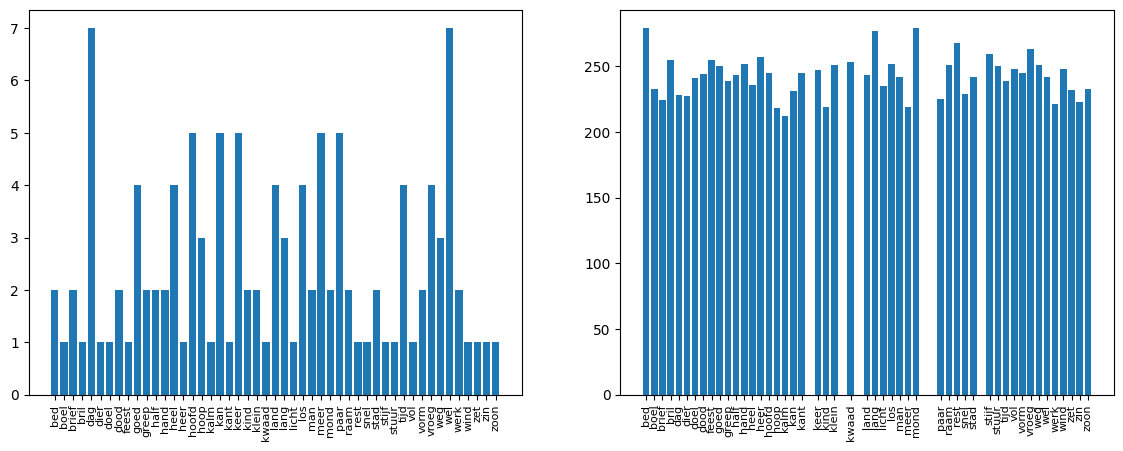

In [7]:
plt.figure(figsize=(14,5))

plt.subplot(121)
labels_unique, actual_counts = np.unique(trainset.labels(), return_counts=True)
plt.bar(labels_unique, actual_counts)
plt.xticks(labels_unique, np.unique(trainset.labels()), rotation=90, fontsize=8)

plt.subplot(122)
labels_unique, counts = np.unique(labels, return_counts=True)
plt.bar(labels_unique, counts)
plt.xticks(labels_unique, np.unique(trainset.labels()), rotation=90, fontsize=8)

# plt.tight_layout()
plt.show()

## Training

In [8]:
model = nn.Sequential(
    nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
    # nn.ReLU(inplace=True),
    # nn.MaxPool2d(kernel_size=(0,2), stride=(1,2)),

    nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
    # nn.ReLU(inplace=True),
    # nn.MaxPool2d(kernel_size=(0,2), stride=(1,2)),

    nn.Flatten(),

    nn.Linear(6400, 3200),
    nn.ReLU(inplace=True),

    nn.Linear(3200, 1600),
    nn.ReLU(inplace=True),
    
    nn.Linear(1600, 55),
    nn.Softmax(1),
)
x = torch.randn(8,2,32,100)
x = x.permute(0,2,1,3)
x = x.flatten(2)
print('Input\n ', x.shape)
for layer in model:
    x = layer(x)
    print(layer._get_name())
    print(' ', x.shape)
model = model.cuda()

Input
  torch.Size([8, 32, 200])
Conv1d
  torch.Size([8, 64, 100])
Conv1d
  torch.Size([8, 128, 50])
Flatten
  torch.Size([8, 6400])
Linear
  torch.Size([8, 3200])
ReLU
  torch.Size([8, 3200])
Linear
  torch.Size([8, 1600])
ReLU
  torch.Size([8, 1600])
Linear
  torch.Size([8, 55])
Softmax
  torch.Size([8, 55])


In [9]:
LEARNING_RATE = 1e-6
N_EPOCHS = 600

SAVE_ITER = 100

WEIGHT_DECAY = 0 # '0' to turn off
LR_DECAY_STEP_SIZE = None # 'None' to turn off scheduler
LR_DECAY_FACTOR = 0.01

In [10]:
# model = BrainClassifierV1(in_nodes=2*32*SEGMENT_LENGTH, n_classes=n_classes).cuda()
# model = BrainClassifierV3(n_classes).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if LR_DECAY_STEP_SIZE is not None:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

start_epoch = 1
model

Sequential(
  (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=6400, out_features=3200, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=3200, out_features=1600, bias=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=1600, out_features=55, bias=True)
  (8): Softmax(dim=1)
)

In [11]:
# NOTE Change output name here for every experiment
ckpt_path = f'exp/brain_classifier_v3_{n_classes}classes_switch-channels_oversampling/'

os.makedirs(ckpt_path, exist_ok=False)
print(ckpt_path)

exp/brain_classifier_v3_55classes_switch-channels_oversampling/


In [12]:
logs = {
    'train_loss_epoch': [], 'train_loss_batch': [], 'train_acc_epoch': [], 'train_acc_batch': [],
    'val_loss_epoch': [], 'val_loss_batch': [], 'val_acc_epoch': [], 'val_acc_batch': [],
}

In [13]:
for epoch in (pbar := tqdm(range(start_epoch, start_epoch+N_EPOCHS), desc='Training', ncols=100)):
    # TRAINING
    model.train()
    train_loss_epoch = 0.
    train_acc_epoch = 0.
    for i, data in enumerate(trainloader):
        x, y = data
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad()
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        train_loss_batch = loss.item()
        logs['train_loss_batch'].append(train_loss_batch)
        train_loss_epoch += train_loss_batch

        train_acc_batch = accuracy_score(
            torch.argmax(y, dim=1).cpu(), torch.argmax(y_pred, dim=1).cpu())
        logs['train_acc_batch'].append(train_acc_batch)
        train_acc_epoch += train_acc_batch
   
    train_loss_epoch /= len(trainloader)
    logs['train_loss_epoch'].append(train_loss_epoch)

    train_acc_epoch /= len(trainloader)
    logs['train_acc_epoch'].append(train_acc_epoch)

    # VALIDATING
    model.eval()
    val_loss_epoch = 0.
    val_acc_epoch = 0.
    for i, data in enumerate(valloader):
        x, y = data
        x = x.cuda()
        y = y.cuda()
        
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        
        val_loss_batch = loss.item()
        logs['val_loss_batch'].append(val_loss_batch)
        val_loss_epoch += val_loss_batch

        val_acc_batch = accuracy_score(
            torch.argmax(y, dim=1).cpu(), torch.argmax(y_pred, dim=1).cpu())
        logs['val_acc_batch'].append(val_acc_batch)
        val_acc_epoch += val_acc_batch

    val_loss_epoch /= len(valloader)
    logs['val_loss_epoch'].append(val_loss_epoch)

    val_acc_epoch /= len(valloader)
    logs['val_acc_epoch'].append(val_acc_epoch)

    # Update loss values in progress bar
    pbar.set_postfix({
        'Train Loss': round(logs['train_loss_epoch'][-1],3), 
        'Val Loss': round(logs['val_loss_epoch'][-1], 3),
    })

    # Decay learning rate if specified
    if LR_DECAY_STEP_SIZE is not None:
        scheduler.step()

    # Save model checkpoint
    if epoch % SAVE_ITER == 0:
        torch.save(
            {'model_state_dict': model.state_dict()},
            os.path.join(ckpt_path, f'{epoch}.pkl')
        )

start_epoch = epoch + 1

Training: 100%|███████████████████| 600/600 [06:04<00:00,  1.65it/s, Train Loss=3.65, Val Loss=4.01]


Save logs to disk

In [15]:
with open(os.path.join(ckpt_path, 'logs.json'), "w") as f:
    json.dump(logs, f)

## Plotting Logged Metrics

In [9]:
with open(os.path.join(ckpt_path, 'logs.json'), "r") as f:
    logs = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'exp/brain_classifier_v1_55classes_no-dropout/logs.json'

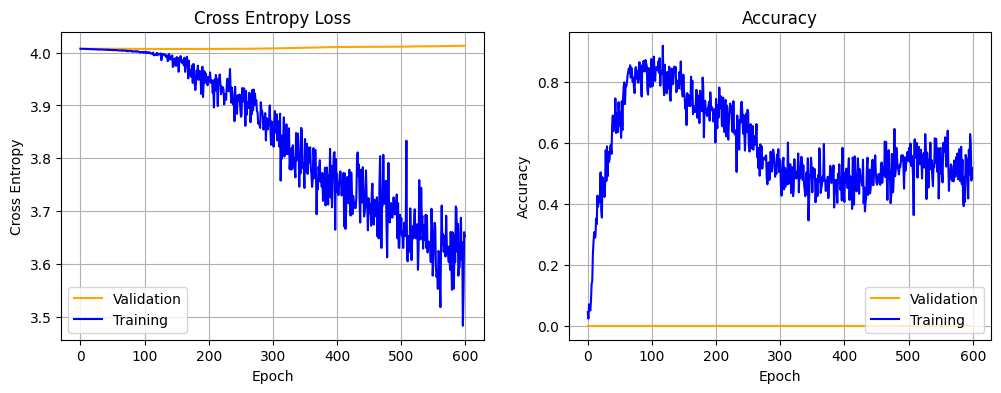

In [16]:
start_idx = 0
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(logs['val_loss_epoch'][start_idx:], color='orange', label='Validation')
plt.plot(logs['train_loss_epoch'][start_idx:], color='b', label='Training')
# plt.vlines(2000, 3.7, 4.0, colors='r', linestyles='--', alpha=0.5)
# plt.vlines(1100, 3.4, 4.1, colors='r', linestyles='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc=3)
plt.grid()

plt.subplot(122)
plt.title('Accuracy')
plt.plot(logs['val_acc_epoch'][start_idx:], color='orange', label='Validation')
plt.plot(logs['train_acc_epoch'][start_idx:], color='b', label='Training')
# plt.vlines(2000, 0.0, 0.325, colors='r', linestyles='--', alpha=0.5)
# plt.vlines(1100, 0.0, 0.75, colors='r', linestyles='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.grid()

plt.show()

## Confusion Matrices

In [57]:
# Load model
epoch_to_load = 100
load_ckpt_path = f'exp/brain_classifier_v3_55classes_switch-channels'

ckpt = torch.load(os.path.join(load_ckpt_path, f'{epoch_to_load}.pkl'))
# model = BrainClassifierV1(in_nodes=2*32*SEGMENT_LENGTH, n_classes=n_classes).cuda()
# model = BrainClassifierV3(n_classes).cuda()
model.load_state_dict(ckpt['model_state_dict'])
model

Sequential(
  (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=6400, out_features=3200, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=3200, out_features=1600, bias=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=1600, out_features=55, bias=True)
  (8): Softmax(dim=1)
)

In [58]:
all_preds_train = np.empty(0)
all_true_train = np.empty(0)
model.eval()
for i, data in enumerate(trainloader):
    x, y = data
    x = x.cuda()
    
    y_pred = model(x)
    all_preds_train = np.concatenate([all_preds_train, torch.argmax(y_pred, dim=1).cpu()])
    all_true_train = np.concatenate([all_true_train, torch.argmax(y, dim=1)])

cm_train = confusion_matrix(all_true_train, all_preds_train, labels=range(n_classes))

print('Unique classes predicted:', list(np.unique(all_preds_train)))

Unique classes predicted: [0.0, 2.0, 3.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 21.0, 22.0, 23.0, 27.0, 30.0, 31.0, 32.0, 33.0, 36.0, 37.0, 39.0, 40.0, 43.0, 44.0, 46.0, 47.0, 48.0, 49.0, 50.0, 52.0, 54.0]


In [59]:
all_preds_val = np.empty(0)
all_true_val = np.empty(0)
model.eval()
for i, data in enumerate(valloader):
    x, y = data
    x = x.cuda()
    
    y_pred = model(x)
    all_preds_val = np.concatenate([all_preds_val, torch.argmax(y_pred, dim=1).cpu()])
    all_true_val = np.concatenate([all_true_val, torch.argmax(y, dim=1)])

cm_val = confusion_matrix(all_true_val, all_preds_val, labels=range(n_classes))

print(all_preds_val)
print(all_true_val)
print('Unique classes predicted:', list(np.unique(all_preds_val)))

[49. 15. 49.  4. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49. 49.]
[ 4.  4.  4.  4.  4. 15. 15. 21. 36. 36. 49. 49. 49. 49. 49.]
Unique classes predicted: [4.0, 15.0, 49.0]


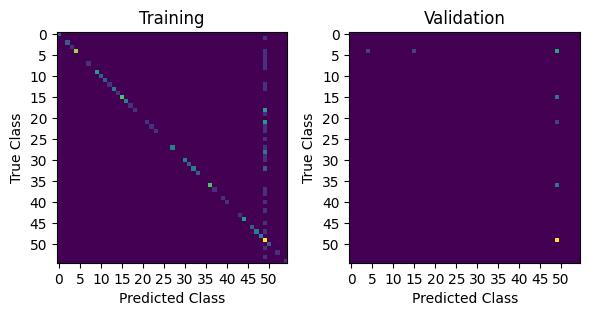

In [60]:
plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(cm_train)
plt.title('Training')
plt.ylabel('True Class')
plt.yticks(range(0,n_classes,5))
plt.xlabel('Predicted Class')
plt.xticks(range(0,n_classes,5))

plt.subplot(122)
plt.imshow(cm_val)
plt.title('Validation')
plt.ylabel('True Class')
plt.yticks(range(0,n_classes,5))
plt.xlabel('Predicted Class')
plt.xticks(range(0,n_classes,5))
# plt.grid()

plt.tight_layout()
plt.show()

In [19]:
def get_word_from_token(token):
    return list(class_label_loader.word_tokens.keys())\
        [list(class_label_loader.word_tokens.values()).index(token)]

In [20]:
[get_word_from_token(t) for t in list(np.unique(all_preds_val))]

['hoofd', 'wel']